In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import ipaddress
import pickle

In [2]:
df = pd.read_csv('cybersecurity_attacks.csv')
df.info

<bound method DataFrame.info of       Timestamp Source IP Address Destination IP Address  Source Port  \
0      06:33:58     103.216.15.12           84.9.164.252        31225   
1      07:08:30    78.199.217.198         66.191.137.154        17245   
2      08:23:25      63.79.210.48          198.219.82.17        16811   
3      10:38:46     163.42.196.10        101.228.192.255        20018   
4      13:11:07     71.166.185.76        189.243.174.238         6131   
...         ...               ...                    ...          ...   
39995  14:08:42      26.36.109.26         121.100.75.240        31005   
39996  00:38:27      17.21.163.81         196.108.134.78         2553   
39997  01:45:49     162.35.217.57            98.107.0.15        22505   
39998  18:32:38    208.72.233.205         173.79.112.252        20013   
39999  11:59:52     14.102.21.108           109.198.45.7        50137   

       Destination Port Protocol  Packet Length Packet Type Traffic Type  \
0              

In [3]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

C:\Users\Deep\AppData\Local\Temp\ipykernel_15456\766710655.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


In [4]:
df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek

In [5]:
# Convert IP addresses to numerical values
def ip_to_int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except:
        return 0 
df['Src_IP_Num'] = df['Source IP Address'].apply(ip_to_int)
df['Dst_IP_Num'] = df['Destination IP Address'].apply(ip_to_int)

In [6]:
# Ensure numerical columns
df['Packet Length'] = pd.to_numeric(df['Packet Length'], errors='coerce')
df['Anomaly Scores'] = pd.to_numeric(df['Anomaly Scores'], errors='coerce')
df['Severity Level'] = pd.to_numeric(df['Severity Level'], errors='coerce') 
# Fill missing values
df.fillna(0, inplace=True) 
# Convert 'IDS/IPS Alerts' column to strings if necessary
df['IDS/IPS Alerts'] = df['IDS/IPS Alerts'].astype(str)

In [7]:
# Encode categorical features
le_protocol = LabelEncoder()
le_traffic_type = LabelEncoder()
le_ids_alerts = LabelEncoder() 

df['Protocol_Encoded'] = le_protocol.fit_transform(df['Protocol'])
df['Traffic_Type_Encoded'] = le_traffic_type.fit_transform(df['Traffic Type'])
df['IDS_Alerts_Encoded'] = le_ids_alerts.fit_transform(df['IDS/IPS Alerts'])

In [8]:
# Define rules to calculate 'Attack Type'
def label_attack(row):
    # Critical Attack: High Anomaly & Severity
    if row['Anomaly Scores'] > 8 and row['Severity Level'] > 8:
        return 'Critical Attack'
    
    # DDoS: Large packets and malicious traffic type
    elif row['Packet Length'] > 1500 and row['Traffic_Type_Encoded'] == le_traffic_type.transform(['Malicious'])[0]:
        return 'DDoS'
    
    # Brute Force: High packet length and TCP protocol
    elif row['Protocol_Encoded'] == le_protocol.transform(['TCP'])[0] and row['Packet Length'] > 1000:
        return 'Brute Force'
    
    # Malware: High Anomaly Score and large number of packets
    elif row['Anomaly Scores'] > 7 and row['Packet Length'] > 1000:
        return 'Malware'
    
    # Normal: Default for non-attack traffic
    else:
        return 'Normal'

def safe_encode(encoder, label):
    """Safely encode labels even if they were not seen during the fit."""
    try:
        return encoder.transform([label])[0]
    except KeyError:
        return -1  # Use a default value like -1 or 'Unknown' for unseen labels

# Now, you can apply the safe encoding to the 'IDS/IPS Alerts' column (if needed)
df['IDS_Alerts_Encoded'] = df['IDS/IPS Alerts'].apply(lambda x: safe_encode(le_ids_alerts, x))

# Check the results to verify everything is correctly encoded
print(df[['Protocol', 'Traffic Type', 'IDS/IPS Alerts', 'Protocol_Encoded', 'Traffic_Type_Encoded', 'IDS_Alerts_Encoded']].head()) 

  Protocol Traffic Type IDS/IPS Alerts  Protocol_Encoded  \
0     ICMP         HTTP              0                 0   
1     ICMP         HTTP              0                 0   
2      UDP         HTTP     Alert Data                 2   
3      UDP         HTTP     Alert Data                 2   
4      TCP          DNS     Alert Data                 1   

   Traffic_Type_Encoded  IDS_Alerts_Encoded  
0                     2                   0  
1                     2                   0  
2                     2                   1  
3                     2                   1  
4                     0                   1  


In [9]:
# Create and populate the 'Attack Type' column
df['Attack Type'] = df.apply(label_attack, axis=1)

In [10]:
le_attack_type = LabelEncoder()
df['Attack_Type_Encoded'] = le_attack_type.fit_transform(df['Attack Type'])

In [11]:
# Define features and target variable
features = [
    'Src_IP_Num', 'Dst_IP_Num', 'Source Port', 'Destination Port', 
    'Protocol_Encoded', 'Packet Length', 'Traffic_Type_Encoded', 
    'Anomaly Scores', 'IDS_Alerts_Encoded', 'Severity Level', 
    'Hour', 'Day', 'DayOfWeek'
]

target = 'Attack_Type_Encoded'

In [12]:
X = df[features]
y = df[target]

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=84)

In [14]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Random Forest

In [15]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=90, random_state=40)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=90, random_state=40)

In [16]:
# Make predictions
y_pred = rf_model.predict(X_test_scaled)

In [17]:
# Classification Report for Random Forest
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_attack_type.classes_))


Classification Report:
              precision    recall  f1-score   support

 Brute Force       1.00      1.00      1.00      3495
     Malware       1.00      1.00      1.00      6500
      Normal       1.00      1.00      1.00     20005

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



In [18]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
                 feature  importance
5          Packet Length    0.694968
4       Protocol_Encoded    0.204254
7         Anomaly Scores    0.039671
0             Src_IP_Num    0.012556
1             Dst_IP_Num    0.012417
3       Destination Port    0.011985
2            Source Port    0.011897
10                  Hour    0.008097
6   Traffic_Type_Encoded    0.002733
8     IDS_Alerts_Encoded    0.001422


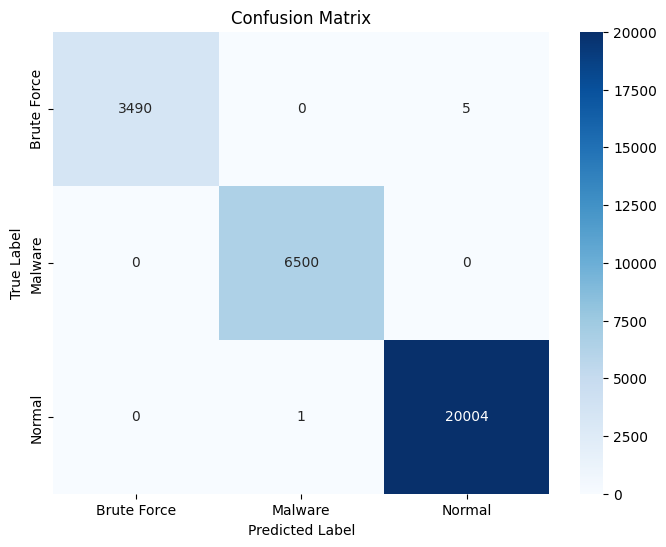


Accuracy of the model: 99.98%


In [19]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_attack_type.classes_, 
            yticklabels=le_attack_type.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print accuracy
print("\nAccuracy of the model: {:.2f}%".format(accuracy * 100))

In [20]:
# Save the trained model
with open('attack_type_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

# Save the scaler
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Save the updated dataset
df.to_csv('predicted_Attack.csv', index=False)
print("\nUpdated dataset saved as 'predicted_attack.csv'")


Updated dataset saved as 'predicted_attack.csv'


SVM Classifier

In [21]:
# Ensure le_attack is defined and used for encoding the attackType labels
le_attack = LabelEncoder()
y_train_encoded = le_attack.fit_transform(y_train)  # Assuming 'y_train' has attackType
y_test_encoded = le_attack.transform(y_test)  # Transform 'y_test' similarly

In [22]:
from sklearn.svm import SVC
model = SVC(kernel='rbf', random_state=35)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [23]:
# Predict the labels for the test set
y_pred = model.predict(X_test_scaled)

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
# Assuming y_test and y_pred are the true and predicted labels
cm = confusion_matrix(y_test, y_pred)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      3495
           1       0.94      0.94      0.94      6500
           2       0.97      0.98      0.97     20005

    accuracy                           0.97     30000
   macro avg       0.96      0.96      0.96     30000
weighted avg       0.97      0.97      0.97     30000



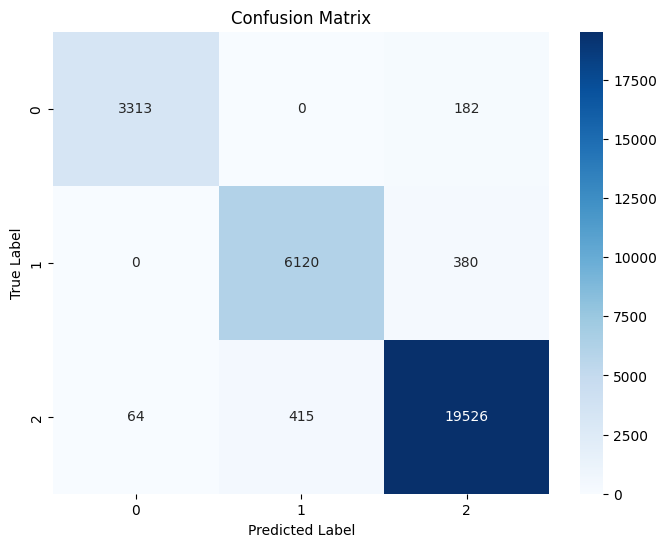

In [25]:
# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels= le_attack.classes_, yticklabels=le_attack.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [26]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy of the SVM model
accuracy_svm = accuracy_score(y_test, y_pred)

# Print the accuracy
print(f"Accuracy of the SVM model: {accuracy_svm * 100:.2f}%")

Accuracy of the SVM model: 96.53%


Deecision Tree Classifier

In [27]:

# Ensure le_attack is defined and used for encoding the attackType labels
le_attack = LabelEncoder()
y_train_encoded = le_attack.fit_transform(y_train)  # Assuming 'y_train' has attackType
y_test_encoded = le_attack.transform(y_test)  # Transform 'y_test' similarly

In [28]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=80)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [29]:
# Predict the labels for the test set
y_pred = model.predict(X_test_scaled)

In [30]:
# Compute the confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)

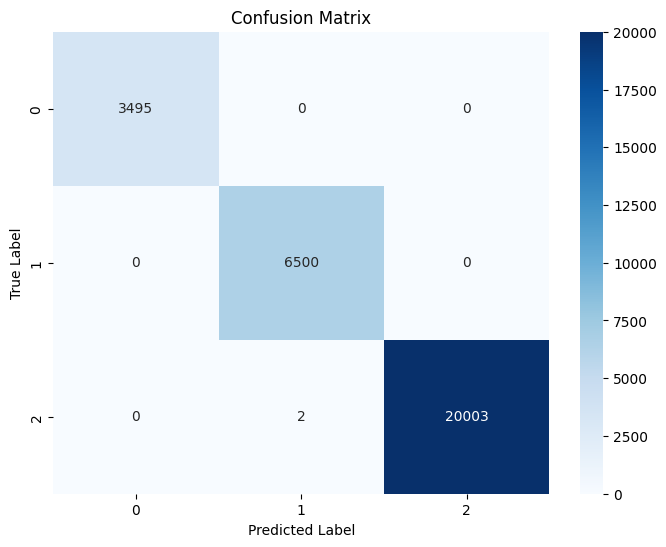

In [31]:
# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_attack.classes_, yticklabels=le_attack.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [32]:
# Calculate the accuracy of the Decision Tree model
from sklearn.metrics import accuracy_score

accuracy_dt = accuracy_score(y_test, y_pred)  # Replace y_pred with the predictions from the Decision Tree model
print("\nAccuracy of the Decision Tree model: {:.2f}%".format(accuracy_dt * 100))


Accuracy of the Decision Tree model: 99.99%


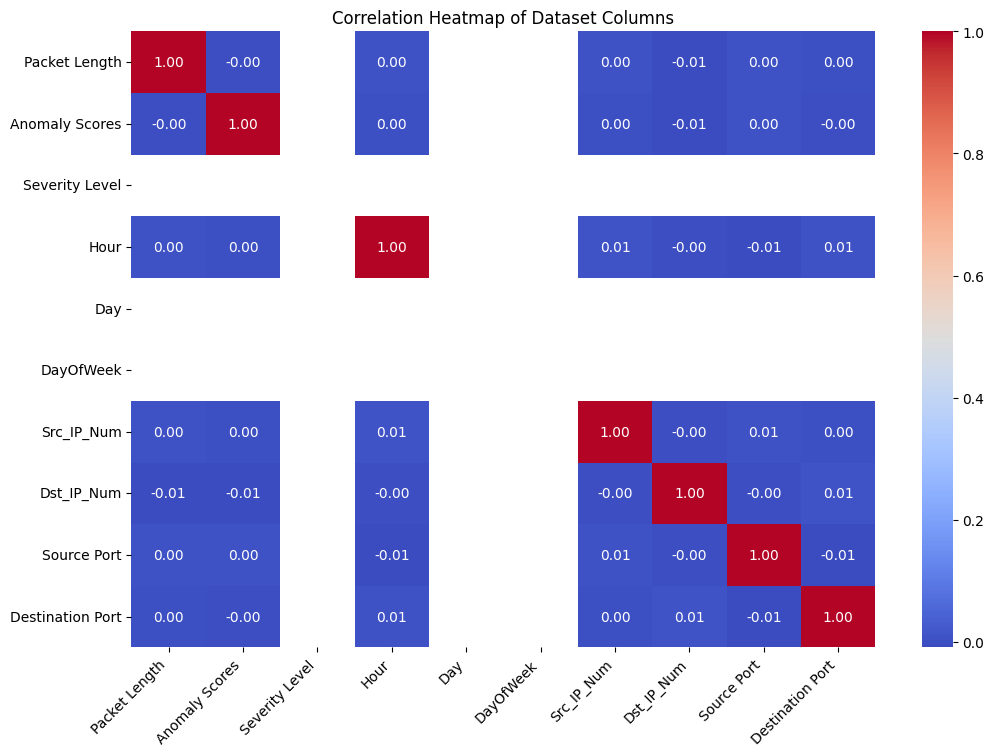

In [33]:
# Select relevant numerical columns for correlation
correlation_columns = [
    'Packet Length', 'Anomaly Scores', 'Severity Level', 
    'Hour', 'Day', 'DayOfWeek', 'Src_IP_Num', 'Dst_IP_Num', 
    'Source Port', 'Destination Port'
]

# Calculate correlation matrix
correlation_matrix = df[correlation_columns].corr()

# Create heatmap for correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f', 
    cbar=True
)
plt.title('Correlation Heatmap of Dataset Columns')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()
